<a href="https://colab.research.google.com/github/karasu1982/POS_Data_Analytics/blob/main/notebook/%E5%A3%B2%E4%B8%8A%E5%88%86%E8%A7%A3%E3%83%84%E3%83%AA%E3%83%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 売上分解ツリー
売上分解ツリーは、企業や店舗全体の売上がどの様な構成になっていて、何が要因で上昇・下降しているのかを把握するための第一歩となる分析です。

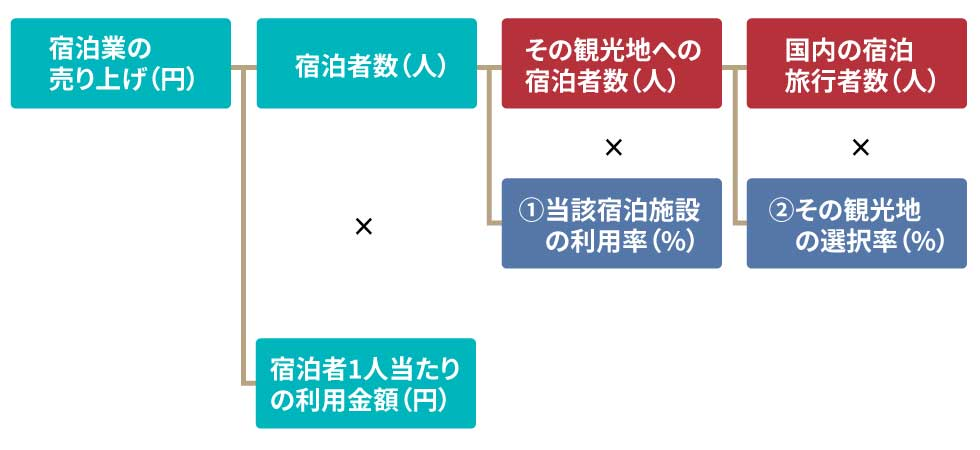

参考：「誰でもできる無料データで「売上減の理由」を見つける方法」

分解の方法は様々なやり方がありますが、まずは、一番の基本として次のような分解を考えてみましょう。

1.   売上をまずは、客数 × 客単価に分ける。
2.   客数は、ユニーク客数 × 来店回数に分解する。
3.   客単価は、商品購入個数 × 商品単価に分解する。




## 環境設定

In [1]:
%%bash
pip install duckdb-engine

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.1/43.1 kB 1.1 MB/s eta 0:00:00


In [2]:
# 標準ライブラリ
import pandas as pd
import numpy as np

# DuckDB
import duckdb

## データ準備

ID-POSのサンプルデータとして、下記を利用

https://www.kyoritsu-pub.co.jp/book/b10003634.html

In [ ]:
%%bash
wget https://kyoritsu-pub.sakura.ne.jp/app/file/goods_contents/2319.zip
unzip /content/2319.zip
unzip /content/DataProcess.20151001/src/data/Tafeng/Tafeng.zip

In [4]:
df = pd.read_csv("/content/Tafeng_dataset/Tafeng.csv")

# データ型を
df = df.astype({'CustID': 'object', 'ProductSubClass': 'object', 'ProductID': 'object'})

In [5]:
df.head(3)

,Time,CustID,Age,Area,ProductSubClass,ProductID,Amount,Asset,SalesPrice
0,2000-11-01 00:00:00,46855,D,E,110411,4710085120468,3,51,57
1,2000-11-01 00:00:00,539166,E,E,130315,4714981010038,2,56,48
2,2000-11-01 00:00:00,663373,F,E,110217,4710265847666,1,180,135


## データ集計

In [21]:
import duckdb

# SQLに慣れている方にとっては、少々くどいかもしれませんが、可読性を高めるために、処理を１つ１つ分解してWITH句で実行しています。
#
# 私がBigQueryの文法に慣れていることもあり、次の3点で修正が必要でした。他にも微妙な差はありそうなので、都度都度直す必要がありますね。
# ・コメントアウトは#は使わず、-- で行う
# ・文字列はダブルコーテーション（ " )ではなく、シングルクオーテーション（ ' )でくくる
# ・日付項目は、文字列を自動で日付型化しないため、DATETIME '2000-11-01'のように日付型を明示的に指定する
#

df_output = duckdb.query(
    f"""
    WITH t_tran AS (
        SELECT
            CustID,
            COUNT(*) AS Visit,
            SUM(Amount) AS Amount,
            SUM(Amount * SalesPrice) AS  Sales
        FROM df
        WHERE Time BETWEEN '2000-11-01 00:00:00' AND '2000-12-31 23:59:59'
        GROUP BY CustID
    )

    SELECT
        SUM(Sales) AS TotalSales,
        SUM(Visit) AS NumofVisit,
        COUNT(DISTINCT CustID) AS NumofUniqueCustomers,
        SUM(Visit) / COUNT(DISTINCT CustID) AS AvgVisitPerCoustomer,
        SUM(Sales) / SUM(Visit) AS AvgSalesPerCustomer,
        SUM(Amount) / SUM(Visit) AS AvgAmountPerVisit,
        SUM(Sales) / SUM(Amount) AS AvgSalesPrice,
    FROM t_tran
    """
).to_df()

作成したテーブルのアウトプット
*   TotalSales	: 総売り上げ（総来店数 × 1来店あたりの購入金額）
*   NumofVisit : 総来店数（ユニーク顧客数 × 1来店あたりの購入金額）
*   NumofUniqueCustomers : ユニーク顧客数
*   AvgVisitPerCoustomer : 1ユニーク顧客数あたりの来店回数
*   AvgSalesPerVisit : 1来店あたりの購入金額（1来店あたりの購入個数 × 1商品あたりの単価）
*   AvgAmountPerCustomer : 1来店あたりの購入個数
*   AvgSalesPrice : 1商品あたりの単価

In [22]:
 # データ確認
df_output.head(100)

,TotalSales,NumofVisit,NumofUniqueCustomers,AvgVisitPerCoustomer,AvgSalesPerCustomer,AvgAmountPerVisit,AvgSalesPrice
0,294082041.0,401838.0,23589,17.034974,731.842287,1.397185,523.797723


アウトプットは1行になるので、地味目ですが総売り上げを分解していった、それぞれの数値が出力されています。